In [1]:
#モジュールのインポート
"""
・scripts内のkf.pyのインポート
・kf/robot/Ideal_robotなどで呼び出したパッケージを使用するため
    matplot,math,numpyなど
"""
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
#ランドマークの推定位置と誤差楕円(ガウス分布)の描画
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None 
        
    def draw(self, ax, elems): 
        if self.cov is None: #共分散行列がNoneのときは描画しない#ランドマークの誤差楕円描画のため
            return
        
        #推定結果の描画
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [3]:
#FastSLAM用のパーティクル作成クラス
"""
"""
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map() ## パーティクル毎の地図をもてせて推定とする 
        """
        self.map=hat_m^{i}_tは、地図推定に関する変数
        パーティクル毎に地図を確率的に推定したときの確率分布のパラメータが入っている
        地図推定は各ランドマークの位置推定になるので、
        各ランドマークの位置、不確かさを表す変数が入っている 式8.4ランドマーク位置推定問題の分解

        地図に指定された個数だけ、ガウス分布のパラメータを表すクラスのオブジェクトを渡す
        """
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
            
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        """
        初めてランドマークを観測した時、ランドマークの位置推定のガウス分布を初期化する。
        ランドマークの位置推定を行う際、1つ前の情報を使用するために初期化の処理がある
        """
        x, y, t = self.pose #位置
        ell, phi = z #センサ値
         
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
        #センサ値を、パーティクルの姿勢に基づいて世界座標系にランドマーク位置を変換したもの
        #初期のガウス分布の中心、以後のmを変数とするガウス分布に近似するのに用いる
    
        # h(m):自己位置推定においての観測方程式をmx,myまわりで偏微分した
        # ランドマークの観測方程式h(m)を線形化した行列Hを算出
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        # あらかじめ設定したランドマークの観測における誤差の標準偏差から共分散行列Qを算出
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        #求めたH,Qをもちいて初期のガウス分布の共分散行列をもとめ、mを中心とする
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        landmark.pos = np.array([mx, my]).T
        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        x, y, _ = self.pose
        mx, my =  landmark.pos
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos) #ランドマークの推定位置から予想された計測値
        estm_ell, _ = estm_z
        if estm_ell < 0.01: #推定位置が近すぎると計算がおかしくなるための回避
            return
        
        #カルマンフィルタを用いて更新
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        #信念位置と推定位置から共分散行列を求め、雑音の分散
        
        #カルマンゲインの算出
        #カルマンゲインは計測値を信念に反映した分布となっている、ひとつ前の分布から算出した分中心が動いていることを表す
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        Q_z = H.dot(landmark.cov).dot(H.T) + Q #センサ値のガウス分布の共分散行列を求める
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z) 
        #scipyの多次元ガウス分布を使用、確率密度分布
        #ランドマークの推定位置から予想される計測値と推定の誤差楕円を使用して重みの更新を行う
        
        ###ランドマークの推定の更新###
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        #分布の移動に対して計測値を考慮して更新
        
    def observation_update(self, observation, distance_dev_rate, direction_dev):
        """
        ランドマーク毎にfor文をまわして、ランドマークが初観測の場合は、init_landmark_estimationを呼び出す
        それ以外はobservation_update_landmark
        ランドマークのガウス分布の初期値の設定方法があるため場合分け
        """
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)
        ## EstimatedLandmarkへ算出した分布を送る

In [4]:
#FastSlam用のパーティクルの用意
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        #?super().__init__(None, init_pose, landmark_num, motion_noise_stds, distance_dev_rate, direction_dev)
        """
        Mclオブジェクト生成後、super()でMclオブジェクトを継承
        パーティクルをFastSLAM用にするためMcl用にパーティクルは破棄
        パーティクルはMapParticleで割り当てられる 
        
        mlでは重みが最大のパーティクル情報を設定
        """
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):  
        #動作モデルを元にパーティクルを分散
        #重みの計算
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        #更新した地図を評価
        self.set_ml()
        self.resampling() 
        
    def draw(self, ax, elems):
        """
        継承したMclのdrawを呼び出して、座標系からパーティクルの姿勢を描画
        重みが最大のパーティクルがもっている地図の描画
        """
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

<IPython.core.display.Javascript object>


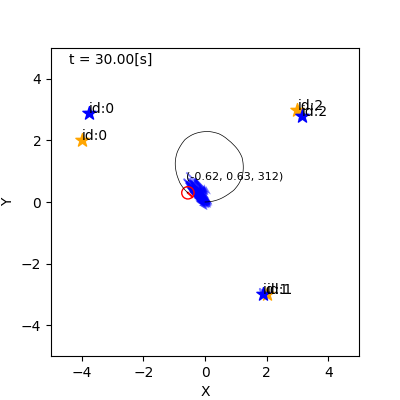

In [5]:
"""
白地図を用意
"""
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###環境となる地図を作成 ランドマークも作る
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)] ##ランドマークの位置
    for p in landmark_positions:
        m.append_landmark(Landmark(*p)) ##Mapにランドマークを置いていく
        
    world.append(m) ## 描画に作成した環境の追加

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T ##ロボットの初期位置 SLAM上での世界座標系
    pf = FastSlam(100, init_pose, len(m.landmarks)) ##  
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red") 
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05